In [1]:
import torch
import intel_extension_for_pytorch as ipex
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR




#hyperparamiter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import torch.optim as optim

torch.manual_seed(42)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libpng16.so.16: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/intel_extension_for_pytorch/llm/__init__.py:9: UserWarning: failed to use huggingface generation fuctions due to: No module named 'transformers'.
  warnings.warn(f"failed to use huggingface generation fuctions due to: {e}.")


In [2]:
import pandas as pd
import numpy as np
import os
import glob
#import shap
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn import metrics
#from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

#When using colab...
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Data/'

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
df = pd.read_csv('Data/2013-24_model_input_cluster_update_v4.csv')

In [5]:
rolling_stats = [col for col in df.columns if col.endswith('_rolling')]

# create opponent columns and compute the difference for each rolling stat
for stat in rolling_stats:
    # Shift to get opponent's stats
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[stat].shift(-1)
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']

# for the second team (reverse the shift), fill in the NaN values
for stat in rolling_stats:
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[f'opp_{stat}'].fillna(df.groupby('GAME_ID')[stat].shift(1))
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']  # Difference between team's and opponent's rolling stats

# NaN check
print(df.isnull().sum())

SEASON_YEAR                0
TEAM_ID                    0
TEAM_ABBREVIATION_x        0
TEAM_NAME_x                0
GAME_ID                    0
                          ..
diff_PACE_PER40_rolling    0
opp_POSS_rolling           0
diff_POSS_rolling          0
opp_PIE_rolling            0
diff_PIE_rolling           0
Length: 189, dtype: int64


In [6]:
## match up teams and create diff column
# identify the rolling stats columns
rolling_stats = [col for col in df.columns if col.endswith('_rolling')] + ['win_percentage']

cluster_cols = [col for col in df.columns if col.startswith('cluster_')]

for stat in rolling_stats:
    # Shift to get opponent's stats
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[stat].shift(-1)
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']

for cluster in cluster_cols:
    # Shift to get opponent's clusters
    df[f'opp_{cluster}'] = df.groupby('GAME_ID')[cluster].shift(-1)
    df[f'diff_{cluster}'] = df[cluster] - df[f'opp_{cluster}']

for stat in rolling_stats:
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[f'opp_{stat}'].fillna(df.groupby('GAME_ID')[stat].shift(1))
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']  

for cluster in cluster_cols:
    df[f'opp_{cluster}'] = df.groupby('GAME_ID')[f'opp_{cluster}'].fillna(df.groupby('GAME_ID')[cluster].shift(1))
    df[f'diff_{cluster}'] = df[cluster] - df[f'opp_{cluster}']

In [7]:
df

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,Season,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_AWAY,cumulative_wins,games_played,win_percentage,FGM_rolling,FGA_rolling,FG_PCT_rolling,FG3M_rolling,FG3A_rolling,FG3_PCT_rolling,FTM_rolling,FTA_rolling,FT_PCT_rolling,OREB_rolling,DREB_rolling,REB_rolling,AST_rolling,TOV_rolling,STL_rolling,BLK_rolling,BLKA_rolling,PF_rolling,PFD_rolling,PTS_rolling,PLUS_MINUS_rolling,E_OFF_RATING_rolling,OFF_RATING_rolling,E_DEF_RATING_rolling,DEF_RATING_rolling,E_NET_RATING_rolling,NET_RATING_rolling,AST_PCT_rolling,AST_TOV_rolling,AST_RATIO_rolling,E_TM_TOV_PCT_rolling,TM_TOV_PCT_rolling,EFG_PCT_rolling,TS_PCT_rolling,E_USG_PCT_rolling,E_PACE_rolling,PACE_rolling,PACE_PER40_rolling,POSS_rolling,PIE_rolling,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,opp_FGM_rolling,diff_FGM_rolling,opp_FGA_rolling,diff_FGA_rolling,opp_FG_PCT_rolling,diff_FG_PCT_rolling,opp_FG3M_rolling,diff_FG3M_rolling,opp_FG3A_rolling,diff_FG3A_rolling,opp_FG3_PCT_rolling,diff_FG3_PCT_rolling,opp_FTM_rolling,diff_FTM_rolling,opp_FTA_rolling,diff_FTA_rolling,opp_FT_PCT_rolling,diff_FT_PCT_rolling,opp_OREB_rolling,diff_OREB_rolling,opp_DREB_rolling,diff_DREB_rolling,opp_REB_rolling,diff_REB_rolling,opp_AST_rolling,diff_AST_rolling,opp_TOV_rolling,diff_TOV_rolling,opp_STL_rolling,diff_STL_rolling,opp_BLK_rolling,diff_BLK_rolling,opp_BLKA_rolling,diff_BLKA_rolling,opp_PF_rolling,diff_PF_rolling,opp_PFD_rolling,diff_PFD_rolling,opp_PTS_rolling,diff_PTS_rolling,opp_PLUS_MINUS_rolling,diff_PLUS_MINUS_rolling,opp_E_OFF_RATING_rolling,diff_E_OFF_RATING_rolling,opp_OFF_RATING_rolling,diff_OFF_RATING_rolling,opp_E_DEF_RATING_rolling,diff_E_DEF_RATING_rolling,opp_DEF_RATING_rolling,diff_DEF_RATING_rolling,opp_E_NET_RATING_rolling,diff_E_NET_RATING_rolling,opp_NET_RATING_rolling,diff_NET_RATING_rolling,opp_AST_PCT_rolling,diff_AST_PCT_rolling,opp_AST_TOV_rolling,diff_AST_TOV_rolling,opp_AST_RATIO_rolling,diff_AST_RATIO_rolling,opp_E_TM_TOV_PCT_rolling,diff_E_TM_TOV_PCT_rolling,opp_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,opp_EFG_PCT_rolling,diff_EFG_PCT_rolling,opp_TS_PCT_rolling,diff_TS_PCT_rolling,opp_E_USG_PCT_rolling,diff_E_USG_PCT_rolling,opp_E_PACE_rolling,diff_E_PACE_rolling,opp_PACE_rolling,diff_PACE_rolling,opp_PACE_PER40_rolling,diff_PACE_PER40_rolling,opp_POSS_rolling,diff_POSS_rolling,opp_PIE_rolling,diff_PIE_rolling,opp_opp_FGM_rolling,diff_opp_FGM_rolling,opp_diff_FGM_rolling,diff_diff_FGM_rolling,opp_opp_FGA_rolling,diff_opp_FGA_rolling,opp_diff_FGA_rolling,diff_diff_FGA_rolling,opp_opp_FG_PCT_rolling,diff_opp_FG_PCT_rolling,opp_diff_FG_PCT_rolling,diff_diff_FG_PCT_rolling,opp_opp_FG3M_rolling,diff_opp_FG3M_rolling,opp_diff_FG3M_rolling,diff_diff_FG3M_rolling,opp_opp_FG3A_rolling,diff_opp_FG3A_rolling,opp_diff_FG3A_rolling,diff_diff_FG3A_rolling,opp_opp_FG3_PCT_rolling,diff_opp_FG3_PCT_rolling,opp_diff_FG3_PCT_rolling,diff_diff_FG3_PCT_rolling,opp_opp_FTM_rolling,diff_opp_FTM_rolling,opp_diff_FTM_rolling,diff_diff_FTM_rolling,opp_opp_FTA_rolling,diff_opp_FTA_rolling,opp_diff_FTA_rolling,diff_diff_FTA_rolling,opp_opp_FT_PCT_rolling,diff_opp_FT_PCT_rolling,opp_diff_FT_PCT_rolling,diff_diff_FT_PCT_rolling,opp_opp_OREB_rolling,diff_opp_OREB_rolling,opp_diff_OREB_rolling,diff_diff_OREB_rolling,opp_opp_DREB_rolling,diff_opp_DREB_rolling,opp_diff_DREB_rolling,diff_diff_DREB_rolling,opp_opp_REB_rolling,diff_opp_REB_rolling,opp_diff_REB_rolling,diff_diff_REB_rolling,opp_opp_AST_rolling,diff_opp_AST_rolling,opp_diff_AST_rolling,diff_diff_AST_rolling,opp_opp_TOV_rolling,diff_opp_TOV_rolling,opp_diff_TOV_rolling,diff_diff_TOV_rolling,opp_opp_STL_roll

In [8]:
columns_to_keep = ['SEASON_YEAR', 'TEAM_ID', 'GAME_ID', 'WL', 'HOME_AWAY', 'win_percentage', 'opp_win_percentage'] + \
                  [col for col in df.columns if (col.startswith('diff_') and col.endswith('_rolling')) or col.startswith('diff_cluster_')]
df_model = df[columns_to_keep]

df_model.head()

,SEASON_YEAR,TEAM_ID,GAME_ID,WL,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_E_OFF_RATING_rolling,diff_OFF_RATING_rolling,diff_E_DEF_RATING_rolling,diff_DEF_RATING_rolling,diff_E_NET_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_E_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_E_USG_PCT_rolling,diff_E_PACE_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_opp_FGM_rolling,diff_diff_FGM_rolling,diff_opp_FGA_rolling,diff_diff_FGA_rolling,diff_opp_FG_PCT_rolling,diff_diff_FG_PCT_rolling,diff_opp_FG3M_rolling,diff_diff_FG3M_rolling,diff_opp_FG3A_rolling,diff_diff_FG3A_rolling,diff_opp_FG3_PCT_rolling,diff_diff_FG3_PCT_rolling,diff_opp_FTM_rolling,diff_diff_FTM_rolling,diff_opp_FTA_rolling,diff_diff_FTA_rolling,diff_opp_FT_PCT_rolling,diff_diff_FT_PCT_rolling,diff_opp_OREB_rolling,diff_diff_OREB_rolling,diff_opp_DREB_rolling,diff_diff_DREB_rolling,diff_opp_REB_rolling,diff_diff_REB_rolling,diff_opp_AST_rolling,diff_diff_AST_rolling,diff_opp_TOV_rolling,diff_diff_TOV_rolling,diff_opp_STL_rolling,diff_diff_STL_rolling,diff_opp_BLK_rolling,diff_diff_BLK_rolling,diff_opp_BLKA_rolling,diff_diff_BLKA_rolling,diff_opp_PF_rolling,diff_diff_PF_rolling,diff_opp_PFD_rolling,diff_diff_PFD_rolling,diff_opp_PTS_rolling,diff_diff_PTS_rolling,diff_opp_PLUS_MINUS_rolling,diff_diff_PLUS_MINUS_rolling,diff_opp_E_OFF_RATING_rolling,diff_diff_E_OFF_RATING_rolling,diff_opp_OFF_RATING_rolling,diff_diff_OFF_RATING_rolling,diff_opp_E_DEF_RATING_rolling,diff_diff_E_DEF_RATING_rolling,diff_opp_DEF_RATING_rolling,diff_diff_DEF_RATING_rolling,diff_opp_E_NET_RATING_rolling,diff_diff_E_NET_RATING_rolling,diff_opp_NET_RATING_rolling,diff_diff_NET_RATING_rolling,diff_opp_AST_PCT_rolling,diff_diff_AST_PCT_rolling,diff_opp_AST_TOV_rolling,diff_diff_AST_TOV_rolling,diff_opp_AST_RATIO_rolling,diff_diff_AST_RATIO_rolling,diff_opp_E_TM_TOV_PCT_rolling,diff_diff_E_TM_TOV_PCT_rolling,diff_opp_TM_TOV_PCT_rolling,diff_diff_TM_TOV_PCT_rolling,diff_opp_EFG_PCT_rolling,diff_diff_EFG_PCT_rolling,diff_opp_TS_PCT_rolling,diff_diff_TS_PCT_rolling,diff_opp_E_USG_PCT_rolling,diff_diff_E_USG_PCT_rolling,diff_opp_E_PACE_rolling,diff_diff_E_PACE_rolling,diff_opp_PACE_rolling,diff_diff_PACE_rolling,diff_opp_PACE_PER40_rolling,diff_diff_PACE_PER40_rolling,diff_opp_POSS_rolling,diff_diff_POSS_rolling,diff_opp_PIE_rolling,diff_diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10
0,2013-14,1610612737,21300023,1,1,0.000000,1.000000,-1.000000,-10.000000,0.045000,3.000000,7.000000,0.039000,15.000000,12.000000,0.249000,-14.000000,-1.000000,-15.000000,12.000000,-1.000000,7.000000,-1.000000,-5.000000,-5.000000,-5.000000,16.000000,-15.000000,7.600,3.700000,24.500000,20.000000,-16.900000,-16.300000,0.335000,0.760000,8.300000,-2.482000,-3.300000,0.068000,0.112000,0.001000,7.540000,11.500000,9.580000,12.000000,-0.049000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.062429,-0.001571,0.019857,0.024857,0.0,0.0,0.040714,-0.022571,0.012571,0.0
1,2013-14,1610612737,21300046,0,0,0.500000,0.333333,0.833333,-11.500000,0.073833,-1.000000,-1.166667,-0.023667,6.500000,8.666667,0.003667,-5.6666

In [9]:
 df_model[df_model['GAME_ID'].astype(str).str.endswith('0001')]

,SEASON_YEAR,TEAM_ID,GAME_ID,WL,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_E_OFF_RATING_rolling,diff_OFF_RATING_rolling,diff_E_DEF_RATING_rolling,diff_DEF_RATING_rolling,diff_E_NET_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_E_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_E_USG_PCT_rolling,diff_E_PACE_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_opp_FGM_rolling,diff_diff_FGM_rolling,diff_opp_FGA_rolling,diff_diff_FGA_rolling,diff_opp_FG_PCT_rolling,diff_diff_FG_PCT_rolling,diff_opp_FG3M_rolling,diff_diff_FG3M_rolling,diff_opp_FG3A_rolling,diff_diff_FG3A_rolling,diff_opp_FG3_PCT_rolling,diff_diff_FG3_PCT_rolling,diff_opp_FTM_rolling,diff_diff_FTM_rolling,diff_opp_FTA_rolling,diff_diff_FTA_rolling,diff_opp_FT_PCT_rolling,diff_diff_FT_PCT_rolling,diff_opp_OREB_rolling,diff_diff_OREB_rolling,diff_opp_DREB_rolling,diff_diff_DREB_rolling,diff_opp_REB_rolling,diff_diff_REB_rolling,diff_opp_AST_rolling,diff_diff_AST_rolling,diff_opp_TOV_rolling,diff_diff_TOV_rolling,diff_opp_STL_rolling,diff_diff_STL_rolling,diff_opp_BLK_rolling,diff_diff_BLK_rolling,diff_opp_BLKA_rolling,diff_diff_BLKA_rolling,diff_opp_PF_rolling,diff_diff_PF_rolling,diff_opp_PFD_rolling,diff_diff_PFD_rolling,diff_opp_PTS_rolling,diff_diff_PTS_rolling,diff_opp_PLUS_MINUS_rolling,diff_diff_PLUS_MINUS_rolling,diff_opp_E_OFF_RATING_rolling,diff_diff_E_OFF_RATING_rolling,diff_opp_OFF_RATING_rolling,diff_diff_OFF_RATING_rolling,diff_opp_E_DEF_RATING_rolling,diff_diff_E_DEF_RATING_rolling,diff_opp_DEF_RATING_rolling,diff_diff_DEF_RATING_rolling,diff_opp_E_NET_RATING_rolling,diff_diff_E_NET_RATING_rolling,diff_opp_NET_RATING_rolling,diff_diff_NET_RATING_rolling,diff_opp_AST_PCT_rolling,diff_diff_AST_PCT_rolling,diff_opp_AST_TOV_rolling,diff_diff_AST_TOV_rolling,diff_opp_AST_RATIO_rolling,diff_diff_AST_RATIO_rolling,diff_opp_E_TM_TOV_PCT_rolling,diff_diff_E_TM_TOV_PCT_rolling,diff_opp_TM_TOV_PCT_rolling,diff_diff_TM_TOV_PCT_rolling,diff_opp_EFG_PCT_rolling,diff_diff_EFG_PCT_rolling,diff_opp_TS_PCT_rolling,diff_diff_TS_PCT_rolling,diff_opp_E_USG_PCT_rolling,diff_diff_E_USG_PCT_rolling,diff_opp_E_PACE_rolling,diff_diff_E_PACE_rolling,diff_opp_PACE_rolling,diff_diff_PACE_rolling,diff_opp_PACE_PER40_rolling,diff_diff_PACE_PER40_rolling,diff_opp_POSS_rolling,diff_diff_POSS_rolling,diff_opp_PIE_rolling,diff_diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10


In [10]:
len(list(df.columns))

373

In [132]:
# List of columns to keep
columns_to_keep = [
    'SEASON_YEAR',
    'TEAM_ID',
    'GAME_ID',
    'WL',
    'HOME_AWAY',
    'win_percentage',
    'opp_win_percentage',
    'diff_FGM_rolling',
    'diff_FGA_rolling',
    'diff_FG_PCT_rolling',
    'diff_FG3M_rolling',
    'diff_FG3A_rolling',
    'diff_FG3_PCT_rolling',
    'diff_FTM_rolling',
    'diff_FTA_rolling',
    'diff_FT_PCT_rolling',
    'diff_OREB_rolling',
    'diff_DREB_rolling',
    'diff_REB_rolling',
    'diff_AST_rolling',
    'diff_TOV_rolling',
    'diff_STL_rolling',
    'diff_BLK_rolling',
    'diff_BLKA_rolling',
    'diff_PF_rolling',
    'diff_PFD_rolling',
    'diff_PTS_rolling',
    'diff_PLUS_MINUS_rolling',
    #'diff_E_OFF_RATING_rolling',
    'diff_OFF_RATING_rolling',
    #'diff_E_DEF_RATING_rolling',
    'diff_DEF_RATING_rolling',
   # 'diff_E_NET_RATING_rolling',
    'diff_NET_RATING_rolling',
    'diff_AST_PCT_rolling',
    'diff_AST_TOV_rolling',
    'diff_AST_RATIO_rolling',
    #'diff_E_TM_TOV_PCT_rolling',
    'diff_TM_TOV_PCT_rolling',
    'diff_EFG_PCT_rolling',
    'diff_TS_PCT_rolling',
   # 'diff_E_USG_PCT_rolling',
   # 'diff_E_PACE_rolling',
    'diff_PACE_rolling',
    'diff_PACE_PER40_rolling',
    'diff_POSS_rolling',
    'diff_PIE_rolling',
    'diff_cluster_0',
    'diff_cluster_1',
    'diff_cluster_2',
    'diff_cluster_3',
    'diff_cluster_4',
    'diff_cluster_5',
    'diff_cluster_6',
    'diff_cluster_7',
    'diff_cluster_8',
    'diff_cluster_9',
    'diff_cluster_10',

]

df_model_cleaned = df_model[columns_to_keep]



In [12]:
df_model_cleaned

,SEASON_YEAR,TEAM_ID,GAME_ID,WL,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_E_OFF_RATING_rolling,diff_OFF_RATING_rolling,diff_E_DEF_RATING_rolling,diff_DEF_RATING_rolling,diff_E_NET_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_E_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_E_USG_PCT_rolling,diff_E_PACE_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10
0,2013-14,1610612737,21300023,1,1,0.000000,1.000000,-1.000000,-10.000000,0.045000,3.000000,7.000000,0.039000,15.000000,12.000000,0.249000,-14.000000,-1.000000,-15.000000,12.000000,-1.000000,7.000000,-1.000000,-5.000000,-5.000000,-5.000000,16.000000,-15.000000,7.600,3.700000,24.500000,20.000000,-16.900000,-16.300000,0.335000,0.760000,8.300000,-2.482000,-3.300000,0.068000,0.112000,0.001000,7.540000,11.500000,9.580000,12.000000,-0.049000,0.000000,-0.062429,-0.001571,0.019857,0.024857,0.00000,0.000000,0.040714,-0.022571,0.012571,0.000000
1,2013-14,1610612737,21300046,0,0,0.500000,0.333333,0.833333,-11.500000,0.073833,-1.000000,-1.166667,-0.023667,6.500000,8.666667,0.003667,-5.666667,-5.000000,-10.666667,4.166667,-1.000000,5.833333,-1.666667,-0.333333,-5.333333,3.166667,7.166667,7.000000,10.250,7.066667,3.083333,0.666667,7.183333,6.433333,0.090500,0.333333,3.616667,-0.487167,-1.033333,0.075500,0.083500,0.003000,-2.896667,-0.083333,-0.066667,0.166667,0.100333,0.000000,0.074429,0.051571,-0.130771,-0.101543,0.00000,0.000000,-0.214800,-0.278514,-0.099286,0.000000
2,2013-14,1610612737,21300059,1,0,0.333333,0.333333,4.666667,-1.333333,0.063667,2.333333,1.666667,0.070667,0.333333,4.333333,-0.112000,-5.000000,4.333333,-0.666667,9.000000,1.333333,2.666667,-0.666667,-2.666667,-5.666667,-0.333333,12.000000,4.666667,5.100,2.500000,-0.633333,-2.000000,5.766667,4.500000,0.179000,0.446667,5.633333,0.396000,0.100000,0.078333,0.061333,0.002000,7.046667,8.833333,7.363333,9.333333,0.085667,0.000000,-0.005190,0.109714,0.025500,-0.091762,0.00000,0.000000,-0.046548,-0.061214,-0.091095,0.000000
3,2013-14,1610612737,21300071,0,0,0.500000,0.000000,3.000000,-6.000000,0.064667,2.083333,5.416667,0.005250,3.333333,5.833333,-0.068750,-4.916667,-2.583333,-7.500000,7.416667,-1.416667,6.416667,-2.166667,-2.250000,-3.750000,-0.083333,11.416667,8.583333,11.325,8.700000,1.983333,0.291667,9.341667,8.408333,0.152833,0.238333,5.233333,-1.320000,-1.741667,0.080000,0.075083,0.000667,0.511667,2.625000,2.190000,2.916667,0.074917,0.000000,0.034571,0.093857,0.100143,0.038429,0.00000,0.000000,0.186429,-0.153857,-0.118429,0.000000
4,2013-14,1610612737,21300086,1,1,0.400000,0.500000,1.000000,4.500000,-0.016250,2.000000,4.500000,0.022750,-0.750000,1.750000,-0.081750,-0.500000,-8.000000,-8.500000,6.500000,-4.500000,2.250000,0.750000,0.500000,-1.750000,1.500000,3.250000,-9.750000,1.950,1.150000,12.225000,11.800000,-10.275000,-10.650000,0.147000,0.937500,3.850000,-4.730750,-4.975000,-0.007500,-0.016250,-0.001000,1.100000,1.875000,1.565000,2.250000,-0.057500,0.000000,0.022571,0.112857,0.201571,-0.117429,0.00000,0.000000,0.041286,-0.151571,-0.054571,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25975,2023-24,1610612766,22301135,0,1,0.240000,0.680000,0.500000,-1.75

# Inferential Stats

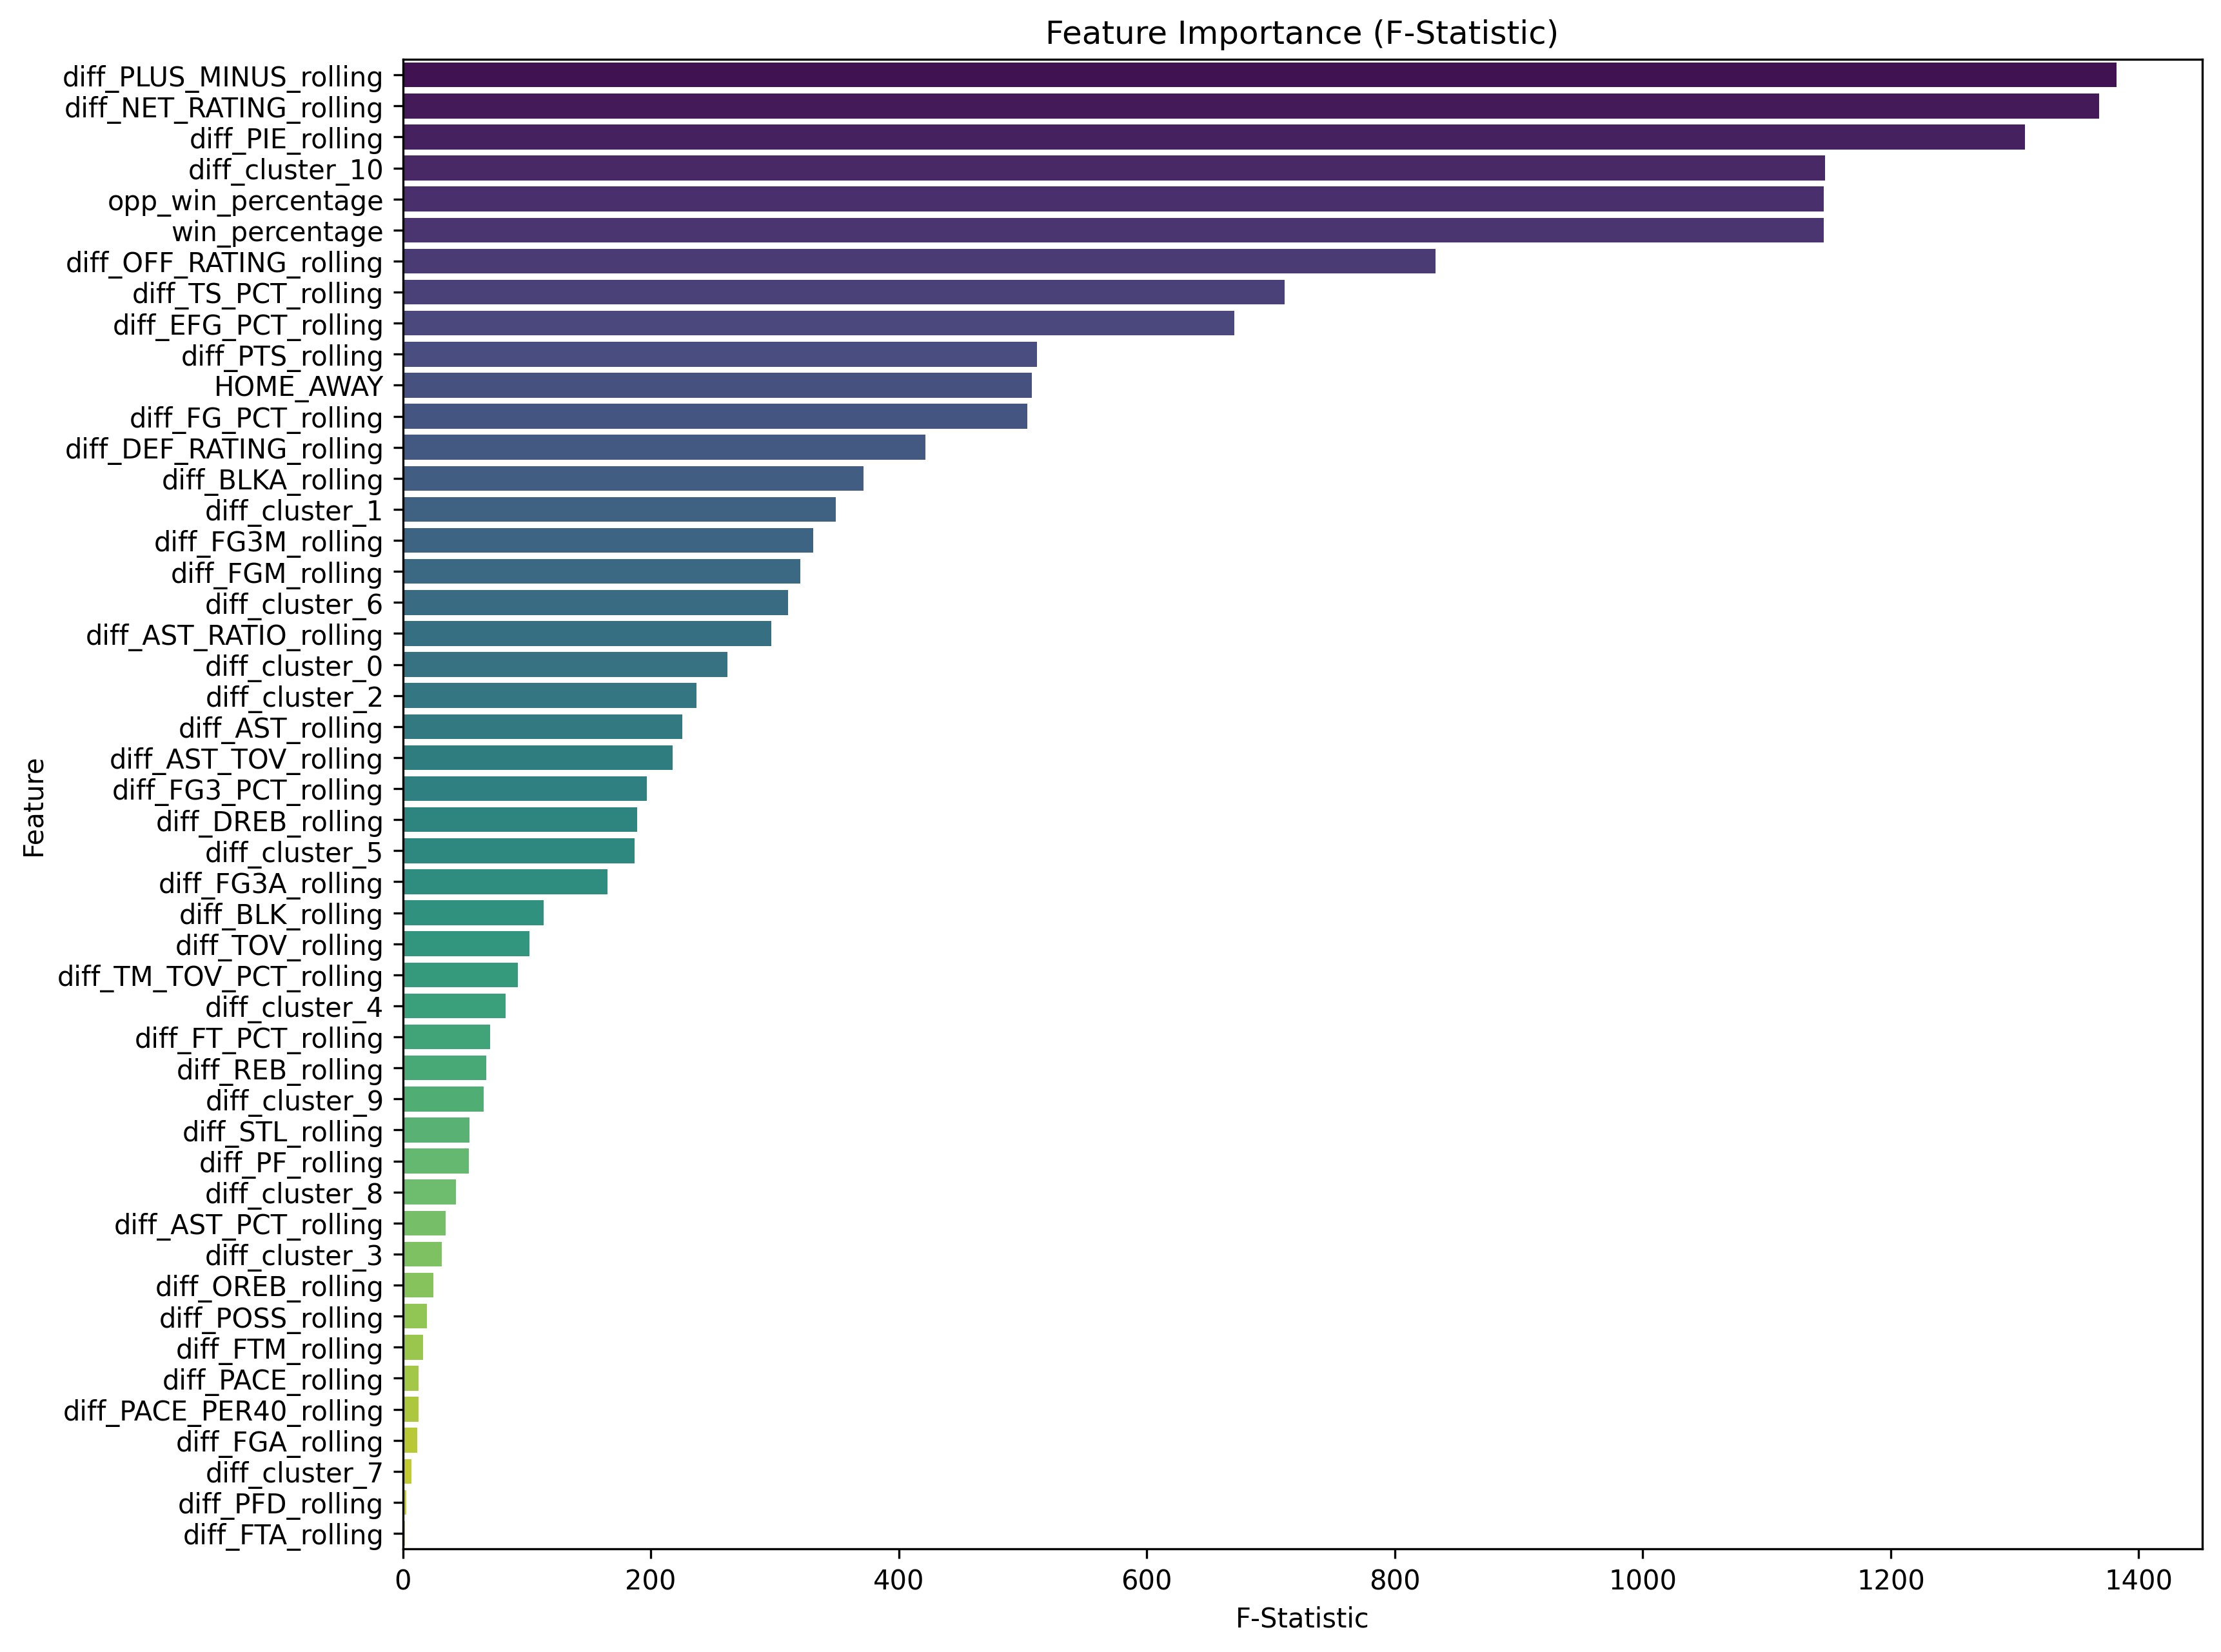

In [133]:
from sklearn.feature_selection import f_classif

y = df_model_cleaned[['WL']]
X = df_model_cleaned.drop('WL',axis=1).select_dtypes(include=['float64', 'int64']).drop(['TEAM_ID','GAME_ID'],axis = 1)
f_statistic, p_values = f_classif(X, y)

results_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Statistic': f_statistic,
    'p-Value': p_values
})
results_df = results_df.sort_values(by='F-Statistic', ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=300)

sns.barplot(x='F-Statistic', y='Feature', data=results_df, palette='viridis', ax=ax)
ax.set_title('Feature Importance (F-Statistic)')

plt.show()

# Training and Scaling

In [134]:
null_counts = df_model_cleaned.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


In [135]:
scaler = RobustScaler()

# Option A Train and Validation

In [136]:
df_val = df_model_cleaned[df_model_cleaned['SEASON_YEAR'].isin([ '2022-23', '2023-24'])]

#remaining seasons for training
df_train_val = df_model_cleaned[~df_model_cleaned['SEASON_YEAR'].isin([ '2022-23', '2023-24','2013-14'])]

X_train = df_train_val.drop(columns=['SEASON_YEAR', 'WL'])
y_train_A = df_train_val['WL']

X_val = df_val.drop(columns=['SEASON_YEAR', 'WL'])
y_val_A = df_val['WL']

X_train_identifiers = X_train[['TEAM_ID', 'GAME_ID']]
X_val_identifiers = X_val[['TEAM_ID', 'GAME_ID']]

X_train = X_train.drop(columns=['TEAM_ID', 'GAME_ID'])
X_val = X_val.drop(columns=['TEAM_ID', 'GAME_ID'])

print(f"A Training set shape: {X_train.shape}")
print(f"A Validation set shape: {X_val.shape}")


X_train_scaled_A = scaler.fit_transform(X_train)
X_val_scaled_A = scaler.transform(X_val)

X_train_scaled_df_A = pd.DataFrame(X_train_scaled_A, columns=X_train.columns)
X_val_scaled_df_A = pd.DataFrame(X_val_scaled_A, columns=X_val.columns)

A Training set shape: (18734, 48)
A Validation set shape: (4820, 48)


# Option B: Train, Validation and Test

In [137]:
# final two seasons for the test set
df_test = df_model_cleaned[df_model_cleaned['SEASON_YEAR'].isin(['2022-23', '2023-24'])]

# remaining seasons for training and validation
df_train_val = df_model_cleaned[~df_model_cleaned['SEASON_YEAR'].isin(['2022-23', '2023-24','2013-14'])]


X_train_val = df_train_val.drop(columns=['SEASON_YEAR', 'WL'])
y_train_val = df_train_val['WL']

X_test = df_test.drop(columns=['SEASON_YEAR', 'WL'])
y_test_B = df_test['WL']

# 80/20 split for training and val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_b, y_val_b = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(f"B Training set shape: {X_train.shape}")
print(f"B Validation set shape: {X_val.shape}")
print(f"B Test set shape: {X_test.shape}")

X_train_identifiers = X_train[['TEAM_ID', 'GAME_ID']]
X_val_identifiers = X_val[['TEAM_ID', 'GAME_ID']]
X_test_identifiers = X_test[['TEAM_ID', 'GAME_ID']]

X_train = X_train.drop(columns=['TEAM_ID', 'GAME_ID'])
X_val = X_val.drop(columns=['TEAM_ID', 'GAME_ID'])
X_test = X_test.drop(columns=['TEAM_ID', 'GAME_ID'])

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df_B = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df_B = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df_B = pd.DataFrame(X_test_scaled, columns=X_test.columns)

B Training set shape: (14987, 50)
B Validation set shape: (3747, 50)
B Test set shape: (4820, 50)


# Model

## Logistic Regression

## A

In [138]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled_df_A, y_train_A)

LogisticRegression(max_iter=1000, random_state=42)

In [139]:
y_test_pred = log_reg.predict(X_val_scaled_df_A)

val_accuracy = accuracy_score(y_val_A, y_test_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.6340
Confusion Matrix:
[[1528  882]
 [ 882 1528]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2410
           1       0.63      0.63      0.63      2410

    accuracy                           0.63      4820
   macro avg       0.63      0.63      0.63      4820
weighted avg       0.63      0.63      0.63      4820



## B

In [140]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled_df_B, y_train_b)

LogisticRegression(max_iter=1000, random_state=42)

In [141]:
y_test_pred = log_reg.predict(X_test_scaled_df_B)

val_accuracy = accuracy_score(y_test_B, y_test_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.6303
Confusion Matrix:
[[1522  888]
 [ 894 1516]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2410
           1       0.63      0.63      0.63      2410

    accuracy                           0.63      4820
   macro avg       0.63      0.63      0.63      4820
weighted avg       0.63      0.63      0.63      4820



# XGBoost

### Option A 

In [148]:
param_grid = {
    'max_depth': [3,4,5,7],
    'learning_rate': [0.009,0.01,0.02],
    'n_estimators': [100,200,300,500,800],
    'subsample': [0.6,0.7,0.8],
    'colsample_bytree': [0.6,0.7,0.8,0.9]
}

xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled_df_A, y_train_A)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
Best Validation Accuracy: 0.6517554887476452


In [168]:
import xgboost as xgb

# convert the dataset into DMatrix (optimized for XGBoost) -
dtrain = xgb.DMatrix(X_train_scaled_df_A, label=y_train_A)
dval = xgb.DMatrix(X_val_scaled_df_A, label=y_val_A)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,  # learning rate
    'max_depth': 7,
    'subsample': 0.6,
    'colsample_bytree': 0.9,
}

evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=100, early_stopping_rounds=None, evals=evals, verbose_eval=0)

y_val_pred = (xgb_model.predict(dval) > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_val_A, y_val_pred))
print(confusion_matrix(y_val_A, y_val_pred))
print(classification_report(y_val_A, y_val_pred))

Test Accuracy: 0.6363070539419087
[[1535  875]
 [ 878 1532]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2410
           1       0.64      0.64      0.64      2410

    accuracy                           0.64      4820
   macro avg       0.64      0.64      0.64      4820
weighted avg       0.64      0.64      0.64      4820



### Option B

In [156]:
param_grid = {
    'max_depth': [3,4,5,7,10,11],
    'learning_rate': [0.009,0.01,0.02],
    'n_estimators': [100,200,300,500,800],
    'subsample': [0.6,0.7,0.8],
    'colsample_bytree': [0.6,0.7,0.8,0.9]
}

xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled_df_B, y_train_b)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.6}
Best Validation Accuracy: 0.6525645725779148


In [166]:
# convert the dataset into DMatrix (optimized for XGBoost) -
dtrain = xgb.DMatrix(X_train_scaled_df_B, label=y_train)
dval = xgb.DMatrix(X_val_scaled_df_B, label=y_val)
dtest = xgb.DMatrix(X_test_scaled_df_B, label=y_test)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,  # learning rate
    'max_depth': 3,
    'subsample': 0.6,
    'colsample_bytree': 0.9,
}

evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=600, early_stopping_rounds=None, evals=evals, verbose_eval=0)

y_test_pred = (xgb_model.predict(dtest) > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.64149377593361
[[1534  876]
 [ 852 1558]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2410
           1       0.64      0.65      0.64      2410

    accuracy                           0.64      4820
   macro avg       0.64      0.64      0.64      4820
weighted avg       0.64      0.64      0.64      4820



## Neural Net

In [124]:
#prep Data
#convert to tensors
X_train_tensor = torch.tensor(X_train_scaled_df_B.values, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train_b.values, dtype=torch.float32).unsqueeze(1)  
X_val_tensor = torch.tensor(X_val_scaled_df_B.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_b.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled_df_B.values, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test_B.values, dtype=torch.float32).unsqueeze(1)

# combine into tensor dataset 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader instances
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training, No shuffle for testing, tried turning off for stability 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [125]:
device = torch.device('xpu')
# Define the main neural network model
class WinLossNet(nn.Module):
    def __init__(self,layer_sizes, drop_rate = 0.380438):
        super(WinLossNet, self).__init__()

        # main Layers
        self.fc1 = nn.Linear(54, layer_sizes[0])
        self.bn1 = nn.BatchNorm1d(layer_sizes[0])
        
        self.fc2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.bn2 = nn.BatchNorm1d(layer_sizes[1])
        
        self.fc3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.bn3 = nn.BatchNorm1d(layer_sizes[2])
        
        self.fc4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.bn4 = nn.BatchNorm1d(layer_sizes[3])
        
        self.fc5 = nn.Linear(layer_sizes[3], layer_sizes[4])
        self.bn5 = nn.BatchNorm1d(layer_sizes[4])
        
        self.fc6 = nn.Linear(layer_sizes[4], 1)
        
        self.dropout = nn.Dropout(p=drop_rate)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        # main
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        
        x = self.fc6(x)
        return x

In [130]:
# Define the objective function for hyperparameter search, close to hand tuning design above
def objective(params):
    batch_size = params['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = WinLossNet(layer_sizes=params['layer_sizes'],drop_rate=params['drop_rate']).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'],weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=params['patience'], factor= params['factor'])
    
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.float32)

    # Training loop
    model.train()
    for epoch in range(params['epochs']):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct, total,val_loss = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    accuracy = correct / total
    return {'loss': avg_val_loss, 'status': STATUS_OK}

# Define the search space
space = {
    'layer_sizes': hp.choice('layer_sizes', [
        [256, 174, 96, 48, 24],
        [512, 384, 192, 96, 48],
        [256, 128, 64, 32, 16],
        [324, 256, 145, 64, 32],
        [512, 256, 128, 64, 32],
        [640, 320, 160, 80, 40],
        [300, 200, 100, 50, 25],
        [400, 300, 150, 75, 37],
        [600, 450, 225, 112, 56],
        [512, 1024, 512, 256, 128],
        [256, 512, 256, 128, 64]
    ]),
    'drop_rate': hp.uniform('drop_rate', 0.01, 0.7),
    'lr': hp.loguniform('lr', -5, -1),
    'epochs': hp.choice('epochs', [10,15, 20, 25,30]),
    'patience': hp.choice('patience', [2,3,5,6,7,8,9]),
    'factor' : hp.uniform('factor', 0.1,0.7),
    'weight_decay' : hp.loguniform('weight_decay',-5,-1),
    'batch_size' : hp.choice('batch_size', [256])
}


# Begin the hunt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

print(best)


 35%|██████████████████                                  | 209/600 [12:21<23:06,  3.55s/trial, best loss: 0.6369413296381633]


KeyboardInterrupt: 

Epoch [2/25], Training Loss: 0.6357, Training Accuracy: 0.6466,Validation Loss: 0.6380, Validation Accuracy: 0.6424
Epoch [3/25], Training Loss: 0.6327, Training Accuracy: 0.6470,Validation Loss: 0.6501, Validation Accuracy: 0.6509
Epoch [4/25], Training Loss: 0.6327, Training Accuracy: 0.6506,Validation Loss: 0.6359, Validation Accuracy: 0.6499
Epoch [5/25], Training Loss: 0.6298, Training Accuracy: 0.6496,Validation Loss: 0.6338, Validation Accuracy: 0.6507
Epoch [6/25], Training Loss: 0.6305, Training Accuracy: 0.6482,Validation Loss: 0.6362, Validation Accuracy: 0.6384
Epoch [7/25], Training Loss: 0.6312, Training Accuracy: 0.6487,Validation Loss: 0.6412, Validation Accuracy: 0.6389
Epoch [8/25], Training Loss: 0.6281, Training Accuracy: 0.6531,Validation Loss: 0.6391, Validation Accuracy: 0.6312
Epoch [9/25], Training Loss: 0.6289, Training Accuracy: 0.6529,Validation Loss: 0.6417, Validation Accuracy: 0.6448
Epoch [10/25], Training Loss: 0.6282, Training Accuracy: 0.6504,Validati

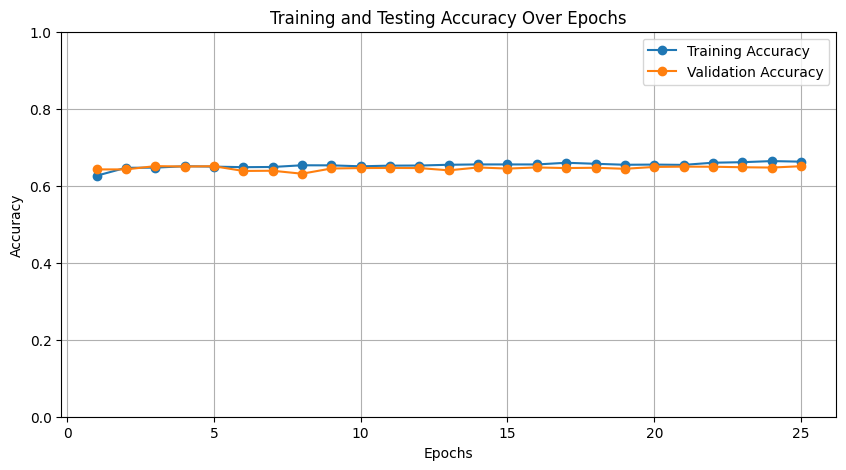

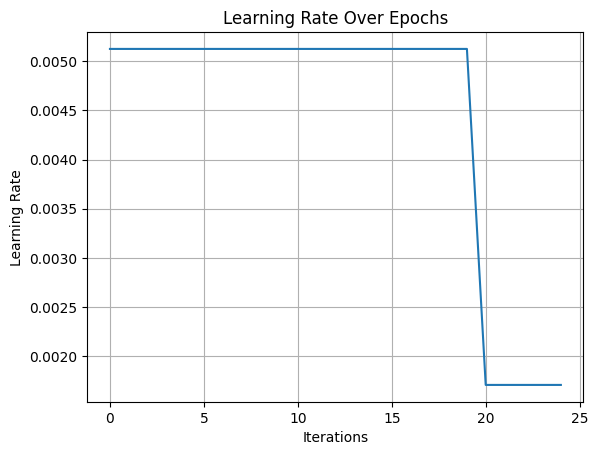

In [126]:
# Instantiate the model, feed weights here to work with search function
model = WinLossNet([512, 1024, 512, 256, 128])

#send to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()   # Combines Sigmoid + BCELoss, feeds data through sigmoid function
optimizer = optim.Adam(model.parameters(), lr=0.0051244,weight_decay=0.000795 )#1e-5)

########even more kaden fun, let 
model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.float32)


train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
learning_rates = []
# knobs
epochs = 25
#scheduler = StepLR(optimizer, step_size=17, gamma=.95)  # Change learning rate over time, different options to test
scheduler = ReduceLROnPlateau(optimizer,patience=6,factor=0.3334,cooldown=0)

for epoch in range(epochs):
    model.train()        # Training time
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)   #issue ******
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    # Calculte the trainging epocs stats
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_preds / total_preds
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)


    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val_preds += labels.size(0)
            correct_val_preds += (predicted == labels).sum().item()

    #calculate validation stats
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = correct_val_preds / total_val_preds
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    if epoch > 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.4f},'
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    # Step the scheduler
    scheduler.step(epoch_val_loss)
    #save chnages in learning rate
    for param_group in optimizer.param_groups:
        learning_rates.append(param_group['lr'])

# Plot plot plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs + 1), train_acc_history, label='Training Accuracy', marker='o')
plt.plot(np.arange(1, epochs + 1), val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epochs')

plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


plt.plot(learning_rates)
plt.title('Learning Rate Over Epochs')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [127]:
torch.save(model.state_dict(), 'model.pth')

best_model = model
#to load model
#model.load_state_dict(torch.load('model.pth'))

In [129]:
 best_model.eval()

true_values = []
predicted_values = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        true_values.append(labels.cpu().numpy())
        predicted_values.append(outputs.cpu().numpy())


true_values = np.concatenate(true_values)
predicted_values = np.concatenate(predicted_values)

results_df = pd.DataFrame({'True_Values':true_values.flatten(),
'pred_Values' : predicted_values.flatten()})
results_df['pred_Values_B'] = (results_df['pred_Values'] > 0.5).astype(int)
results_df = results_df.merge(X_val_identifiers.reset_index().drop('index',axis = 1), left_index=True, right_index=True)
results_df = results_df.merge(X_val.reset_index().drop('index',axis = 1),left_index=True, right_index=True)

predicted_values = (predicted_values >= 0.5).astype(int)
(predicted_values == true_values).mean()


np.float64(0.637551867219917)

In [60]:
results_df['correct_prediction'] = (results_df['True_Values'] == results_df['pred_Values_B']).astype(int)
results_df

,True_Values,pred_Values,pred_Values_B,TEAM_ID,GAME_ID,HOME_AWAY,win_percentage,opp_win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,diff_FG3A_rolling,diff_FG3_PCT_rolling,diff_FTM_rolling,diff_FTA_rolling,diff_FT_PCT_rolling,diff_OREB_rolling,diff_DREB_rolling,diff_REB_rolling,diff_AST_rolling,diff_TOV_rolling,diff_STL_rolling,diff_BLK_rolling,diff_BLKA_rolling,diff_PF_rolling,diff_PFD_rolling,diff_PTS_rolling,diff_PLUS_MINUS_rolling,diff_E_OFF_RATING_rolling,diff_OFF_RATING_rolling,diff_E_DEF_RATING_rolling,diff_DEF_RATING_rolling,diff_E_NET_RATING_rolling,diff_NET_RATING_rolling,diff_AST_PCT_rolling,diff_AST_TOV_rolling,diff_AST_RATIO_rolling,diff_E_TM_TOV_PCT_rolling,diff_TM_TOV_PCT_rolling,diff_EFG_PCT_rolling,diff_TS_PCT_rolling,diff_E_USG_PCT_rolling,diff_E_PACE_rolling,diff_PACE_rolling,diff_PACE_PER40_rolling,diff_POSS_rolling,diff_PIE_rolling,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,diff_cluster_10,correct_prediction
0,1.0,0.899011,1,1610612766,21400224,1,0.250000,0.857143,-2.50,1.00,-0.04175,-4.25,-6.50,-0.08775,0.50,-1.00,0.03800,-0.50,-6.00,-6.50,-3.75,-5.25,-2.00,-2.75,-0.75,0.75,-1.50,-8.75,-21.25,-4.925,-3.675,17.050,18.800,-21.900,-22.475,-0.06175,1.3275,-1.750,-5.04400,-4.975,-0.06850,-0.05475,0.00075,-3.9750,-5.0000,-4.1625,-5.00,-0.12750,-0.140889,0.012540,-0.052222,-0.093444,-0.020984,0.0,0.213000,0.169460,0.027143,0.050778,-0.119714,1
1,0.0,0.773859,1,1610612749,21600362,0,0.500000,0.695652,-3.50,-6.50,-0.00325,-1.50,-0.50,-0.05650,-1.25,0.50,-0.06875,-4.50,3.00,-1.50,-1.00,4.25,-3.00,0.75,1.75,-1.25,-1.50,-9.75,-15.75,-12.775,-15.650,1.750,1.100,-14.550,-16.750,0.02700,-0.7525,-0.275,4.05175,3.900,-0.00725,-0.01175,0.00450,3.1450,4.3750,3.6500,4.50,-0.08875,0.048125,-0.393143,-0.069018,0.372161,0.002786,0.0,0.000000,-0.154250,-0.019339,0.241500,-0.104214,0
2,1.0,0.782894,1,1610612749,21400831,0,0.563636,0.625000,-4.75,-5.00,-0.02925,-2.50,-4.75,-0.02875,4.25,4.50,0.02275,-1.50,2.25,0.75,-2.25,3.75,4.00,1.25,4.50,0.50,0.00,-7.75,-4.50,-10.575,-9.025,-4.025,-3.375,-6.500,-5.650,0.02625,-0.9125,-1.475,3.60925,3.875,-0.04175,-0.02425,-0.00150,1.4200,0.3750,0.3125,0.75,-0.00800,0.000000,0.093375,0.038375,-0.403050,-0.038250,0.0,0.000000,-0.098825,-0.238550,0.193125,-0.061550,1
3,1.0,0.818096,1,1610612763,21700878,1,0.321429,0.596491,-8.50,-3.50,-0.08250,-5.75,-9.00,-0.09300,0.00,-4.25,0.15100,2.25,-2.25,0.00,-1.50,8.00,0.75,0.50,1.00,6.75,-0.25,-22.75,-23.50,-23.525,-20.500,2.525,3.625,-26.025,-24.125,0.08700,-1.1925,-1.325,8.01600,8.900,-0.11450,-0.09100,-0.00125,-0.6700,-2.7500,-2.2925,-3.00,-0.12000,-0.253429,0.036714,0.280571,-0.083143,0.173286,0.0,-0.234571,-0.235000,0.039571,0.021714,0.442429,1
4,0.0,0.429401,0,1610612742,21400706,0,0.645833,0.306122,-2.50,-0.50,-0.02700,4.25,7.50,0.06725,-3.25,-6.50,0.06925,1.50,-0.75,0.75,0.75,-2.00,0.00,1.00,-2.50,-3.00,-1.00,-4.00,8.00,3.600,3.875,-5.525,-4.025,9.125,7.900,0.06325,0.3000,1.250,-1.13150,-1.050,-0.00075,-0.00225,0.00100,-6.3950,-7.1250,-5.9375,-7.00,0.08825,0.000000,0.324000,-0.080571,-0.110857,-0.238714,0.0,0.182429,-0.083429,0.128571,-0.076571,-0.166286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3742,1.0,0.293467,0,1610612746,22100760,0,0.500000,0.352941,-0.75,-3.50,0.01050,-1.25,-7.75,0.05825,2.50,-0.50,0.11500,-5.25,6.50,1.25,-4.00,-2.75,1.50,-2.00,-1.75,-1.25,-3.00,-0.25,22.00,1.175,-0.175,-19.725,-21.800,20.925,21.625,-0.08375,-0.0025,-1.525,-2.26475,-2.525,0.00650,0.02200,0.00025,1.4050,2.6725,2.2250,0.00,0.08850,-0.126167,-0.151500,0.236200,0.300033,-0.245667,0.0,0.000000,1.016000,0.000000,-0.132533,-0.505167,0
3743,0.0,0.580885,1,1610612766,22100810,1,0.518519,0.547170,-7.75,-0.25,-0.08800,-4.25,7.0

## Playing with SHAP

In [206]:
# JS visualization for Jupyter
shap.initjs()

explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_val_scaled_df)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_val_scaled_df.iloc[0,:])

NameError: name 'shap' is not defined

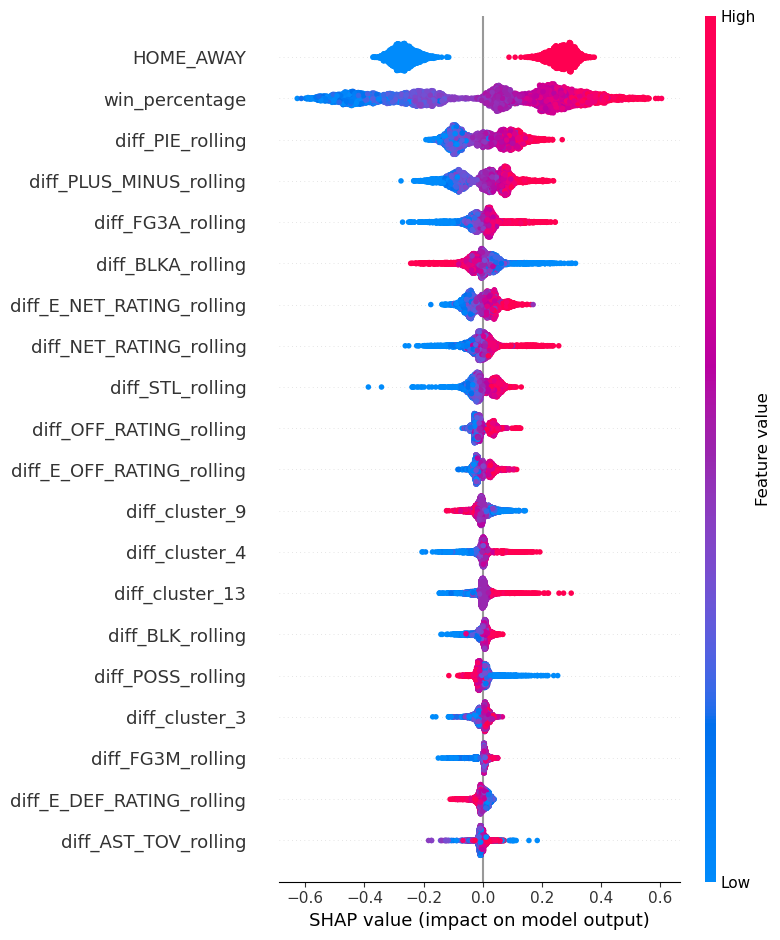

In [37]:
shap.summary_plot(shap_values, X_val_scaled_df)

## Test: Model Blending

In [71]:
log_reg_pred_proba = log_reg.predict_proba(X_val_scaled_df)[:, 1]

xgb_val_pred_proba = xgb_model.predict(dval) 

model.eval()
nn_pred_proba = []
with torch.no_grad():
    for inputs, _ in val_loader: 
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_pred_proba.extend(outputs.cpu().numpy()) 
nn_pred_proba = np.array(nn_pred_proba).flatten()

blended_proba = (log_reg_pred_proba + xgb_val_pred_proba + nn_pred_proba) / 3

blended_pred = (blended_proba >= 0.5).astype(int)

blended_accuracy = accuracy_score(y_val, blended_pred)
print(f"Blended Validation Accuracy: {blended_accuracy:.4f}")

print("Blended Confusion Matrix:")
print(confusion_matrix(y_val, blended_pred))

print("Blended Classification Report:")
print(classification_report(y_val, blended_pred))

Blended Validation Accuracy: 0.6565
Blended Confusion Matrix:
[[1229  645]
 [ 642 1231]]
Blended Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1874
           1       0.66      0.66      0.66      1873

    accuracy                           0.66      3747
   macro avg       0.66      0.66      0.66      3747
weighted avg       0.66      0.66      0.66      3747



## AUC for models/ Final Results

In [66]:
log_reg_test_pred_proba = log_reg.predict_proba(X_test_scaled_df)[:, 1]  
log_reg_test_auc = roc_auc_score(y_test, log_reg_test_pred_proba)
print(f"Logistic Regression Test AUC: {log_reg_test_auc:.4f}")

xgb_test_val_pred_proba = xgb_model.predict(dtest)  
xgb_test_auc = roc_auc_score(y_test, xgb_test_val_pred_proba)
print(f"XGBoost Test AUC: {xgb_test_auc:.4f}")

nn_test_pred_proba = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_test_pred_proba.extend(outputs.cpu().numpy())
nn_test_pred_proba = np.array(nn_test_pred_proba).flatten()
nn_test_auc = roc_auc_score(y_test, nn_test_pred_proba)
print(f"Neural Network Test AUC: {nn_test_auc:.4f}")

blended_test_proba = (log_reg_test_pred_proba + xgb_test_val_pred_proba + nn_test_pred_proba) / 3  # avg prob
blended_test_auc = roc_auc_score(y_test, blended_test_proba)
print(f"Blended Model Test AUC: {blended_test_auc:.4f}")


Logistic Regression Test AUC: 0.6878
XGBoost Test AUC: 0.6910
Neural Network Test AUC: 0.6799
Blended Model Test AUC: 0.6896


In [70]:

# Logistic Regression
log_reg_test_pred = log_reg.predict(X_test_scaled_df)
log_reg_test_accuracy = accuracy_score(y_test, log_reg_test_pred)
print(f"Logistic Regression Test Accuracy: {log_reg_test_accuracy:.4f}")

# XGBoost
xgb_test_val_pred_proba = xgb_model.predict(dtest)
xgb_test_val_pred = (xgb_test_val_pred_proba > 0.5).astype(int) 
xgb_test_accuracy = accuracy_score(y_test, xgb_test_val_pred)
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

# Neural Network
nn_test_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_test_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))  
nn_test_pred = np.array(nn_test_pred).flatten()
nn_test_accuracy = accuracy_score(y_test, nn_test_pred)
print(f"Neural Network Test Accuracy: {nn_test_accuracy:.4f}")

# Blended Model (majority vote)
blended_test_pred = (log_reg_test_pred + xgb_test_val_pred + nn_test_pred) >= 2  
blended_test_accuracy = accuracy_score(y_test, blended_test_pred)
print(f"Blended Model Test Accuracy: {blended_test_accuracy:.4f}")

Logistic Regression Test Accuracy: 0.6342
XGBoost Test Accuracy: 0.6369
Neural Network Test Accuracy: 0.6255
Blended Model Test Accuracy: 0.6353


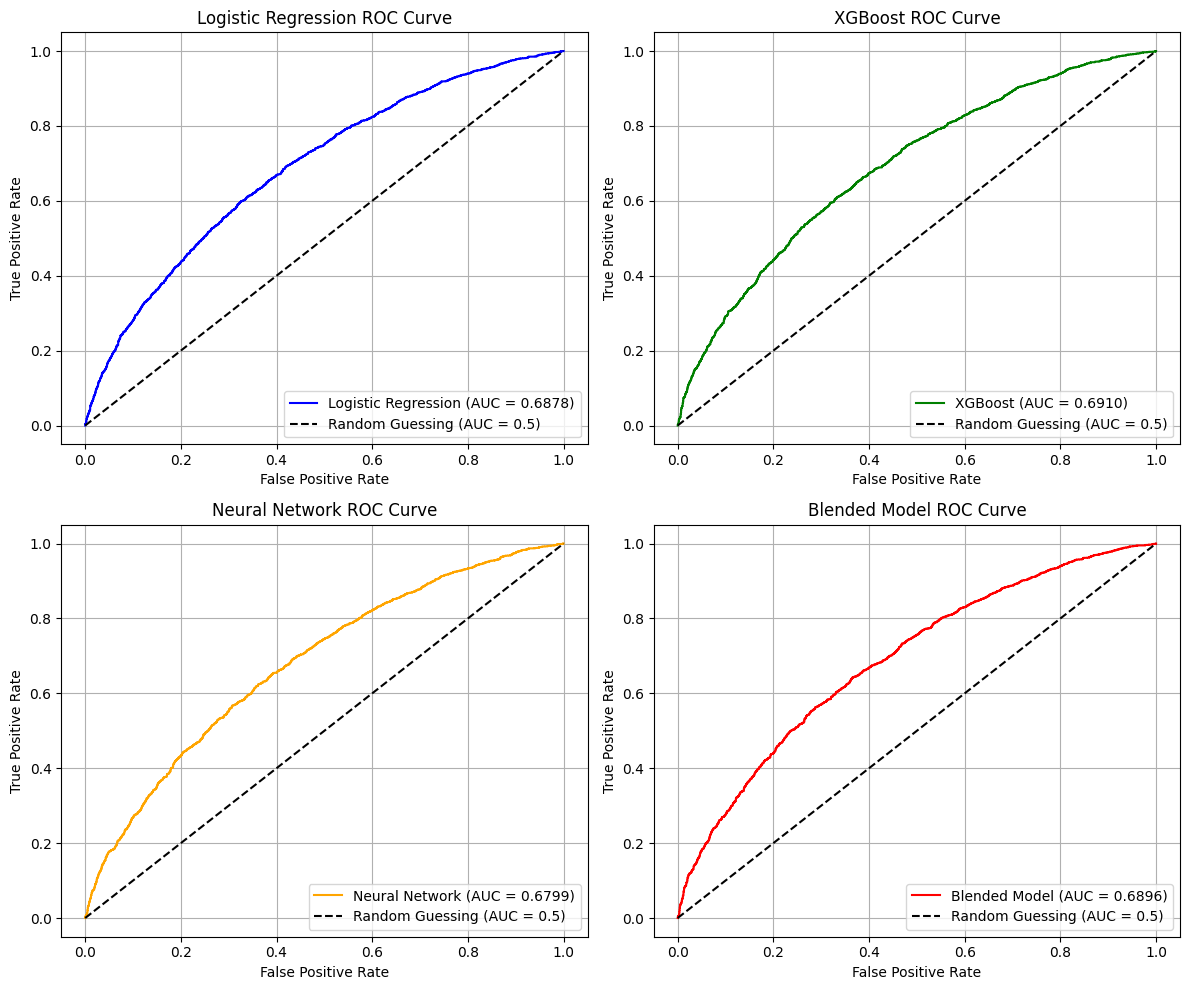

In [63]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_proba)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_val_pred_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_pred_proba)
nn_auc = auc(nn_fpr, nn_tpr)

blended_fpr, blended_tpr, _ = roc_curve(y_test, blended_proba)
blended_auc = auc(blended_fpr, blended_tpr)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(log_reg_fpr, log_reg_tpr, color='blue', label=f'Logistic Regression (AUC = {log_reg_auc:.4f})')
axs[0, 0].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[0, 0].set_title('Logistic Regression ROC Curve')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].legend(loc='lower right')
axs[0, 0].grid(True)

axs[0, 1].plot(xgb_fpr, xgb_tpr, color='green', label=f'XGBoost (AUC = {xgb_auc:.4f})')
axs[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[0, 1].set_title('XGBoost ROC Curve')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].legend(loc='lower right')
axs[0, 1].grid(True)

axs[1, 0].plot(nn_fpr, nn_tpr, color='orange', label=f'Neural Network (AUC = {nn_auc:.4f})')
axs[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[1, 0].set_title('Neural Network ROC Curve')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].legend(loc='lower right')
axs[1, 0].grid(True)

axs[1, 1].plot(blended_fpr, blended_tpr, color='red', label=f'Blended Model (AUC = {blended_auc:.4f})')
axs[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[1, 1].set_title('Blended Model ROC Curve')
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].legend(loc='lower right')
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig('charts/roc_curves_individual.png')
plt.show()

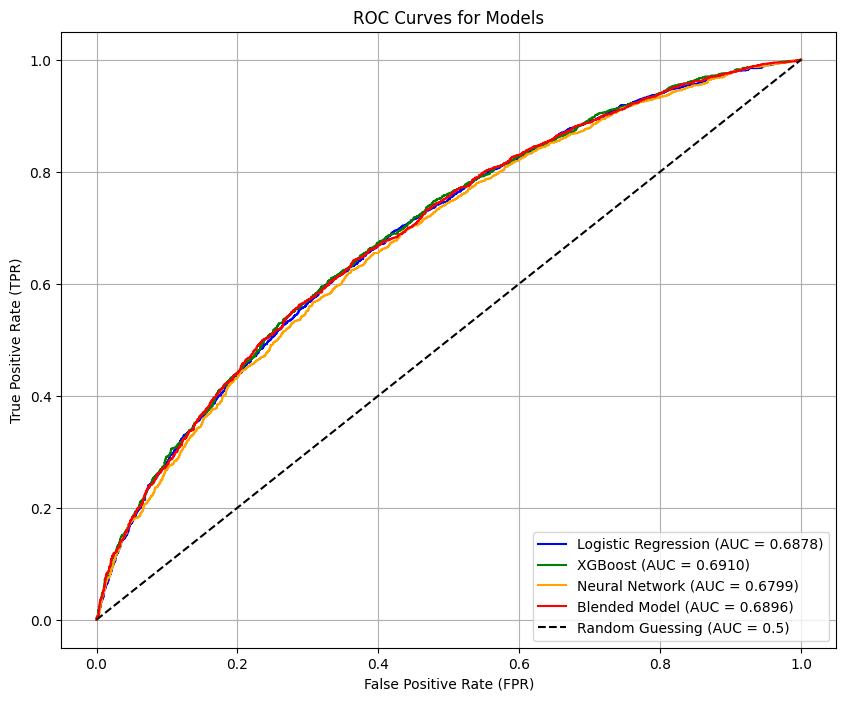

In [64]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_proba)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_val_pred_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_pred_proba)
nn_auc = auc(nn_fpr, nn_tpr)

blended_fpr, blended_tpr, _ = roc_curve(y_test, blended_proba)
blended_auc = auc(blended_fpr, blended_tpr)

plt.figure(figsize=(10, 8))
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.4f})', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})', color='green')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.4f})', color='orange')
plt.plot(blended_fpr, blended_tpr, label=f'Blended Model (AUC = {blended_auc:.4f})', color='red')

# 50% random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')

plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [65]:
xgb_test_pred_proba = xgb_model.predict(dtest)